In [176]:
import pandas as pd
import seaborn as sns
import numpy as np
import geocoder
import gmaps
import statsmodels.api as sm

import pytz

import psycopg2

from sklearn.linear_model import Ridge

import spacy

import swifter

import matplotlib.patches as mpatches

import requests


In [177]:
# Plot settings
%pylab inline

figsize(15, 9)

import matplotlib.style as style

style.use('childsafeai')

Populating the interactive namespace from numpy and matplotlib


In [178]:
from local_settings import GOOGLE_API_KEY

gmaps.configure(GOOGLE_API_KEY)

# Tests

## Processing

In [179]:
tests = requests.get("https://covidtracking.com/api/states/daily").json()
tests_df = pd.DataFrame(tests)
tests_df

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200419,AK,319.0,9576.0,NaN,37.0,36.0,NaN,NaN,NaN,...,36.0,9895.0,9895.0,9895.0,02,0.0,0.0,235.0,5.0,240.0
1,20200419,AL,4837.0,40875.0,NaN,NaN,641.0,NaN,260.0,NaN,...,641.0,45712.0,45712.0,45712.0,01,8.0,21.0,2992.0,182.0,3174.0
2,20200419,AR,1781.0,22428.0,NaN,88.0,291.0,NaN,NaN,25.0,...,291.0,24209.0,24209.0,24209.0,05,2.0,0.0,26.0,42.0,68.0
3,20200419,AS,0.0,3.0,17.0,NaN,NaN,NaN,NaN,NaN,...,NaN,20.0,3.0,3.0,60,0.0,0.0,0.0,0.0,0.0
4,20200419,AZ,4929.0,48061.0,NaN,631.0,NaN,283.0,NaN,187.0,...,NaN,52990.0,52990.0,52990.0,04,7.0,0.0,1735.0,210.0,1945.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,20200301,MI,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9.0,9.0,9.0,26,NaN,NaN,NaN,NaN,NaN
2504,20200301,RI,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,1.0,44,NaN,NaN,NaN,NaN,NaN
2505,20200301,WA,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,30.0,30.0,30.0,53,3.0,0.0,0.0,12.0,12.0
2506,20200229,WA,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.0,18.0,18.0,53,1.0,0.0,0.0,9.0,9.0


In [180]:
tests_df['dateChecked'] = pd.to_datetime(tests_df['dateChecked'])
tests_df['Date'] = pd.to_datetime(tests_df['dateChecked'].dt.date)

In [181]:
tests_df[['positive', 'negative', 'pending', 'death', 'total']] = tests_df[['positive', 'negative', 'pending', 'death', 'total']].astype(int, errors='ignore')

In [182]:
tests_df['completed'] = tests_df['positive'] + tests_df['negative']

In [183]:
us_state_abbreviations = pd.read_csv('data/us_state_abbreviations.csv')
us_state_abbreviations = us_state_abbreviations.groupby('Abbreviation')['Full Name'].max().to_dict()
us_state_abbreviations[np.nan] = 'Unknown'
us_state_abbreviations['DC'] = 'District of Columbia'
us_state_abbreviations['AS'] = 'American Samoa'
us_state_abbreviations['GU'] = 'Guam'
us_state_abbreviations['MP'] = 'Marianas'
us_state_abbreviations['PR'] = 'Marianas'
us_state_abbreviations['VI'] = 'Virgin Island'

tests_df['State'] = tests_df['state'].map(lambda x: us_state_abbreviations[x] if not x == np.nan else x)
tests_df

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,Date,completed,State
0,20200419,AK,319.0,9576.0,NaN,37.0,36.0,NaN,NaN,NaN,...,9895.0,02,0.0,0.0,235.0,5.0,240.0,2020-04-19,9895.0,Alaska
1,20200419,AL,4837.0,40875.0,NaN,NaN,641.0,NaN,260.0,NaN,...,45712.0,01,8.0,21.0,2992.0,182.0,3174.0,2020-04-19,45712.0,Alabama
2,20200419,AR,1781.0,22428.0,NaN,88.0,291.0,NaN,NaN,25.0,...,24209.0,05,2.0,0.0,26.0,42.0,68.0,2020-04-19,24209.0,Arkansas
3,20200419,AS,0.0,3.0,17.0,NaN,NaN,NaN,NaN,NaN,...,3.0,60,0.0,0.0,0.0,0.0,0.0,2020-04-19,3.0,American Samoa
4,20200419,AZ,4929.0,48061.0,NaN,631.0,NaN,283.0,NaN,187.0,...,52990.0,04,7.0,0.0,1735.0,210.0,1945.0,2020-04-19,52990.0,Arizona
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,20200301,MI,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,26,NaN,NaN,NaN,NaN,NaN,2020-03-01,NaN,Michigan
2504,20200301,RI,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,44,NaN,NaN,NaN,NaN,NaN,2020-03-01,NaN,Rhode Island
2505,20200301,WA,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.0,53,3.0,0.0,0.0,12.0,12.0,2020-03-01,NaN,Washington
2506,20200229,WA,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.0,53,1.0,0.0,0.0,9.0,9.0,2020-02-29,NaN,Washington


In [184]:
state_populations = pd.read_excel('data/us_state_populations.xlsx')
tests_df['State Population'] = tests_df['State'].map(lambda x: state_populations[state_populations['State'] == x]['2020 Pop.\xa0'].sum())
tests_df['Tests per Capita'] = (tests_df['total'] / tests_df['State Population'])

In [185]:
%store tests_df

Stored 'tests_df' (DataFrame)


## Analysis

In [186]:
tests_df.groupby('Date')['completed'].sum().max()

3865864.0

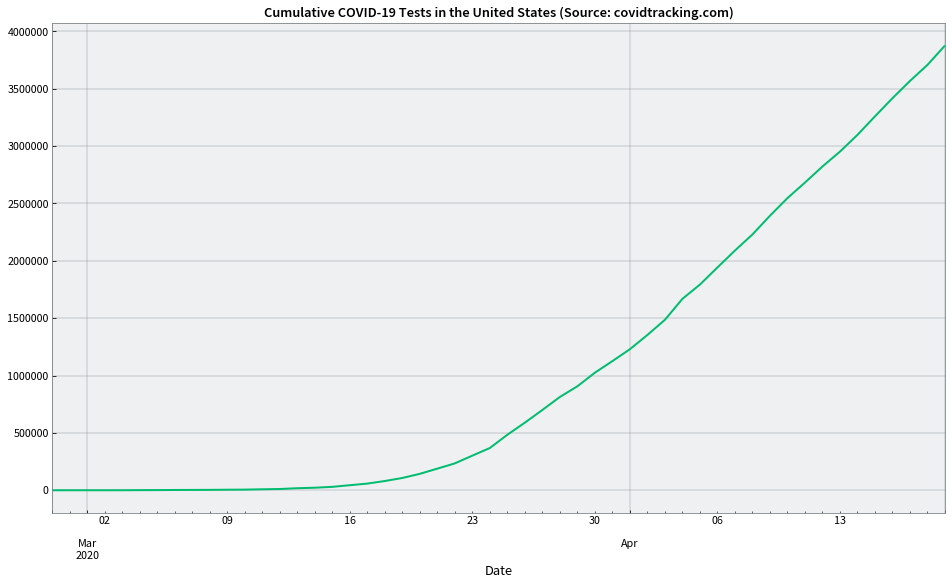

In [187]:
tests_df.groupby('Date')['total'].sum().plot(kind='line', 
                                                    title="Cumulative COVID-19 Tests in the United States (Source: covidtracking.com)")

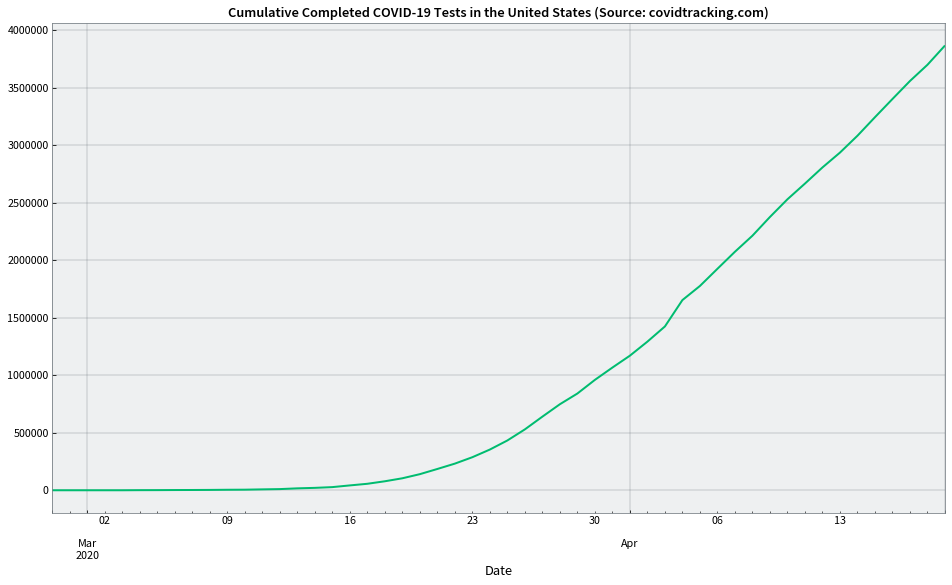

In [188]:
tests_df.groupby('Date')['completed'].sum().plot(kind='line', 
                                                    title="Cumulative Completed COVID-19 Tests in the United States (Source: covidtracking.com)")

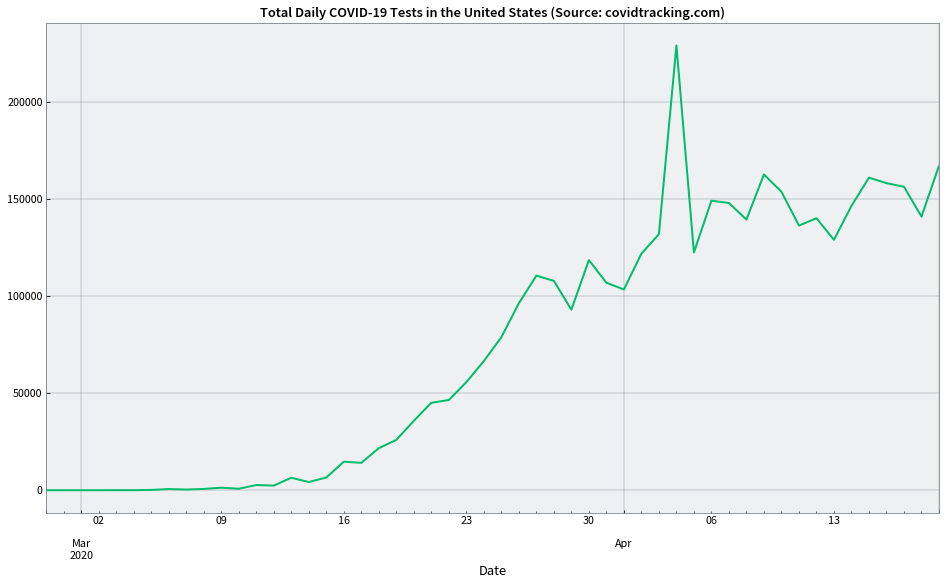

In [189]:
figsize(16, 9)
tests_df.groupby('Date')['totalTestResultsIncrease'].sum().plot(kind='line', 
                                                    title="Total Daily COVID-19 Tests in the United States (Source: covidtracking.com)")

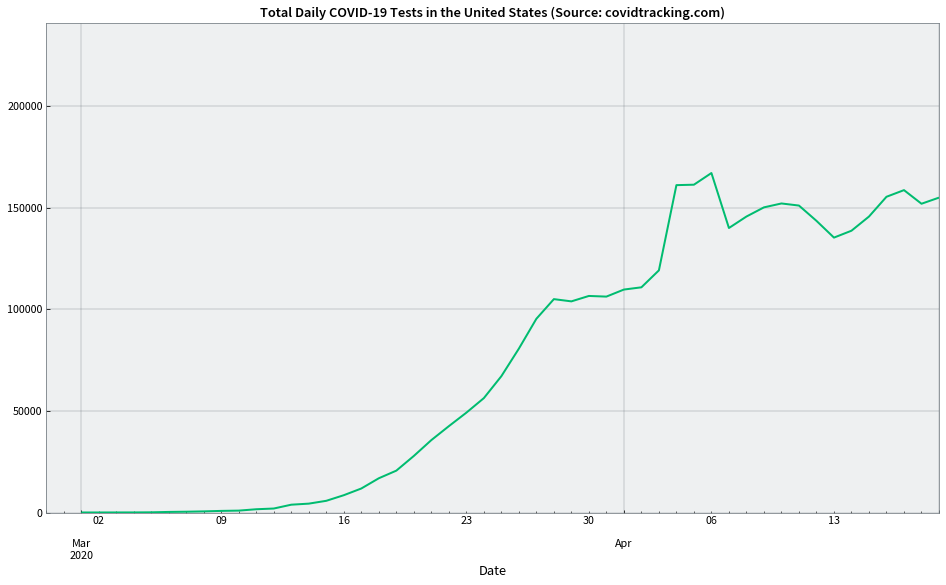

In [190]:
figsize(16, 9)

ax = tests_df.groupby('Date')['totalTestResultsIncrease'].sum().plot(kind='bar')
tests_df.groupby('Date')['totalTestResultsIncrease'].sum().rolling(3).mean().plot(kind='line', label="Rolling 3 Day Avg", ax=ax,
                                                                                       title="Total Daily COVID-19 Tests in the United States (Source: covidtracking.com)")
plt.show()

In [191]:
tests_df.dtypes

date                                      int64
state                                    object
positive                                float64
negative                                float64
pending                                 float64
hospitalizedCurrently                   float64
hospitalizedCumulative                  float64
inIcuCurrently                          float64
inIcuCumulative                         float64
onVentilatorCurrently                   float64
onVentilatorCumulative                  float64
recovered                               float64
hash                                     object
dateChecked                 datetime64[ns, UTC]
death                                   float64
hospitalized                            float64
total                                   float64
totalTestResults                        float64
posNeg                                  float64
fips                                     object
deathIncrease                           

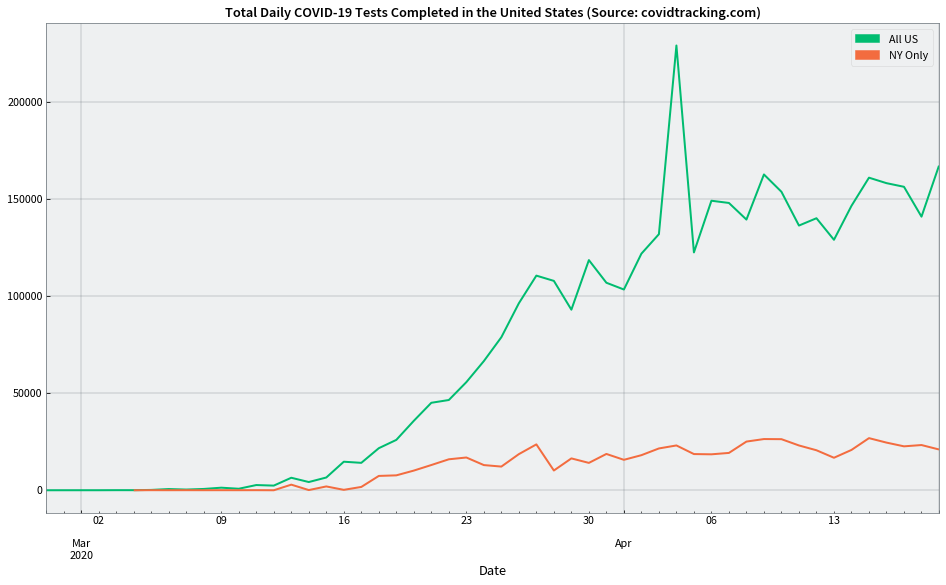

In [192]:
figsize(16, 9)
ax = tests_df.groupby('Date')['totalTestResultsIncrease'].sum().plot(kind='line', label="US",
                                                    title="Total Daily COVID-19 Tests Completed in the United States (Source: covidtracking.com)")

tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['totalTestResultsIncrease'].sum().unstack('state').plot(kind='line', ax=ax)

ax.legend(handles=[mpatches.Patch(color="#00bc70", label="All US"),
                   mpatches.Patch(color="#f36c3f", label="NY Only")])

In [193]:
tests_df[tests_df['Date'] >= '2020-03-23'].groupby('Date')['total'].sum().diff().mean()

132421.88888888888

In [194]:
tests_df[(tests_df['state'] == 'NY') & (tests_df['Date'] >= '2020-03-23')].groupby('Date')['total'].sum().diff().mean()

19972.814814814814

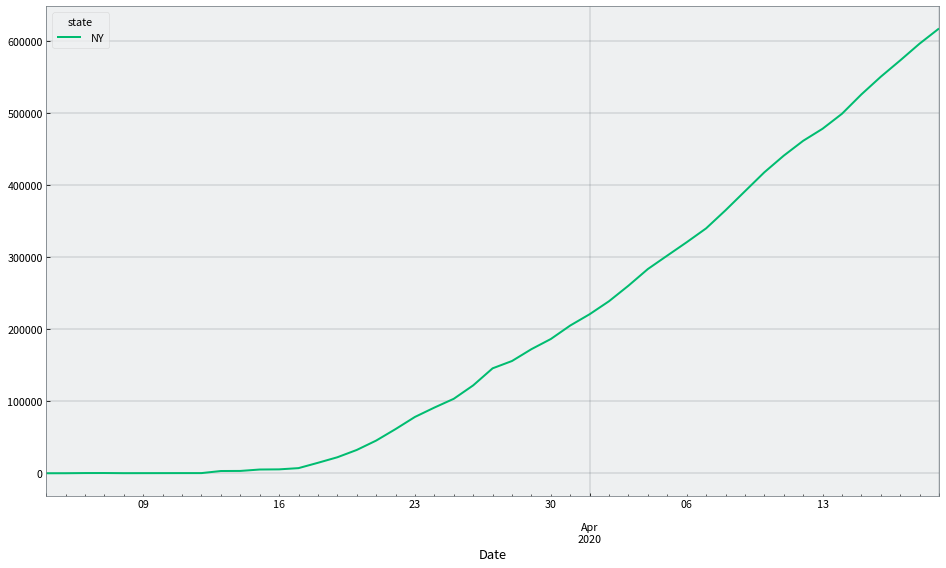

In [195]:
tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line')

In [196]:
tests_df[tests_df['state'] == 'NY'].groupby('Date')['death'].max().diff()

Date
2020-03-04      NaN
2020-03-05      NaN
2020-03-06      NaN
2020-03-07      NaN
2020-03-08      NaN
2020-03-09      NaN
2020-03-10      NaN
2020-03-11      NaN
2020-03-12      NaN
2020-03-13      NaN
2020-03-14      NaN
2020-03-15      NaN
2020-03-16      4.0
2020-03-17      0.0
2020-03-18      5.0
2020-03-19      0.0
2020-03-20     23.0
2020-03-21      9.0
2020-03-22     70.0
2020-03-23      0.0
2020-03-24     96.0
2020-03-25     75.0
2020-03-26    100.0
2020-03-27    134.0
2020-03-28    209.0
2020-03-29    237.0
2020-03-30    253.0
2020-03-31    332.0
2020-04-01    391.0
2020-04-02    432.0
2020-04-03    562.0
2020-04-04    630.0
2020-04-05    594.0
2020-04-06    599.0
2020-04-07    731.0
2020-04-08    779.0
2020-04-09    799.0
2020-04-10    777.0
2020-04-11    783.0
2020-04-12    758.0
2020-04-13    671.0
2020-04-14    778.0
2020-04-15    752.0
2020-04-16    606.0
2020-04-17    630.0
2020-04-18    540.0
2020-04-19    507.0
Name: death, dtype: float64

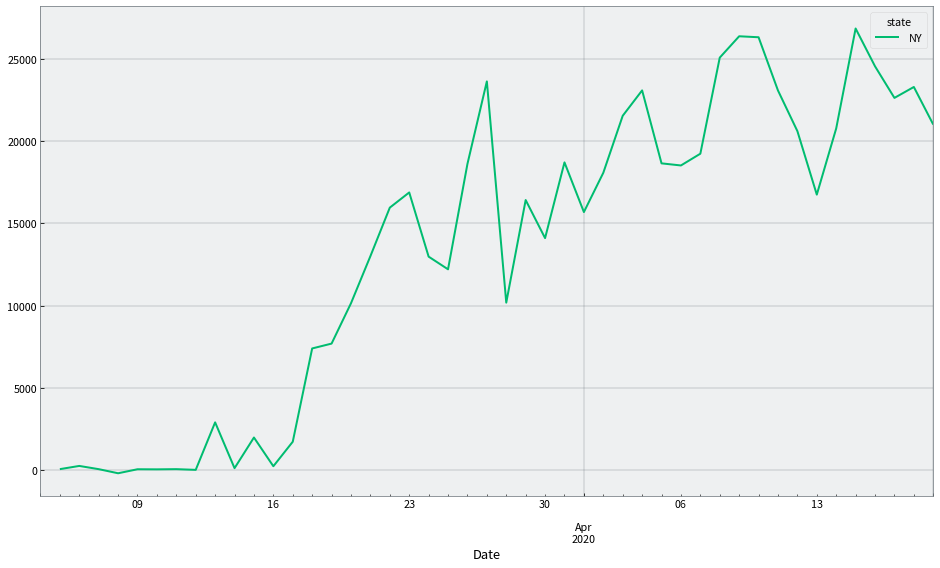

In [197]:
tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['total'].max().diff().unstack('state').plot(kind='line')

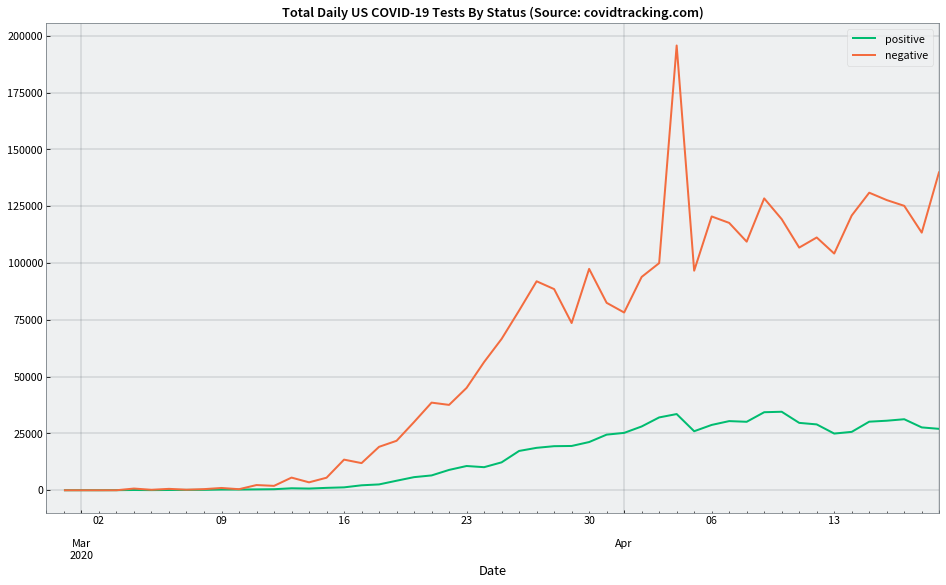

In [198]:
tests_df.groupby('Date')[['positive', 'negative']].sum().diff().plot(kind='line', 
                                                                     title="Total Daily US COVID-19 Tests By Status (Source: covidtracking.com)")

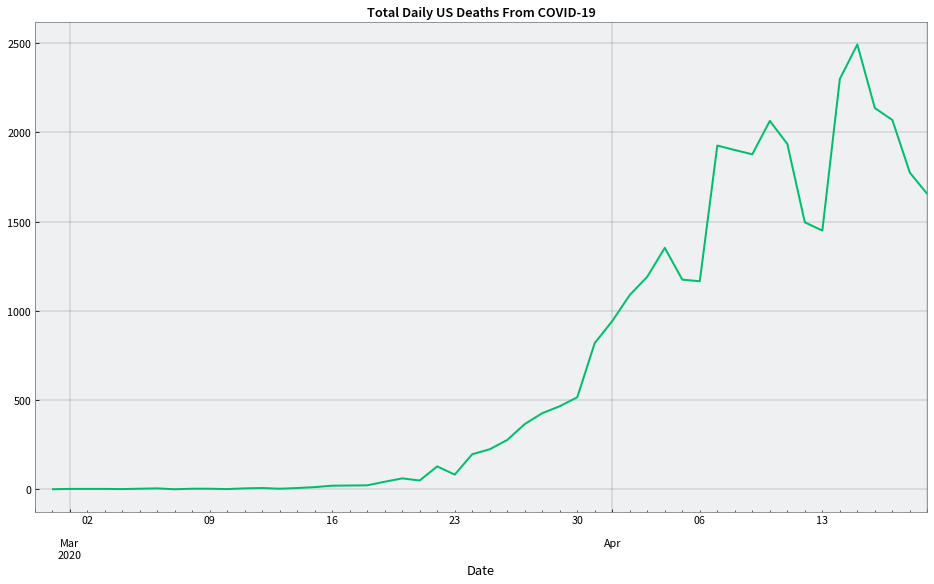

In [199]:
tests_df.groupby('Date')['death'].sum().diff().plot(kind='line',
                                                    title="Total Daily US Deaths From COVID-19")

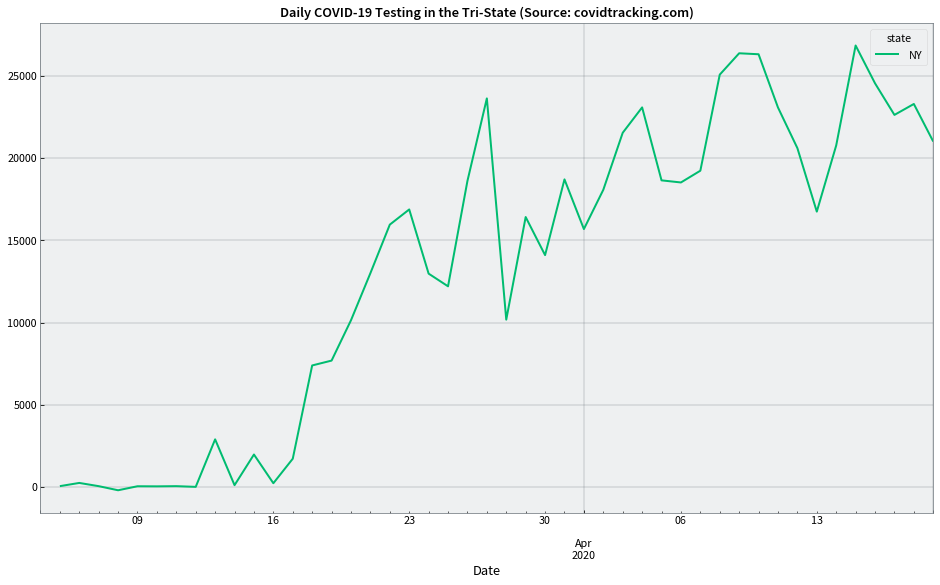

In [200]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY'])].groupby(['Date', 'state'])['total'].max().diff().unstack('state').plot(kind='line',
                                                                                                                     title="Daily COVID-19 Testing in the Tri-State (Source: covidtracking.com)")

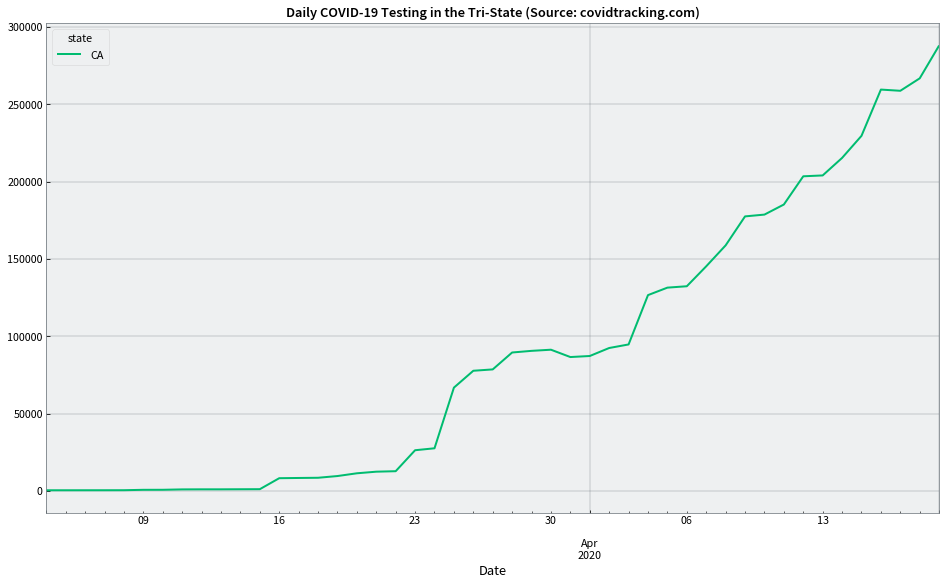

In [201]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['CA'])].groupby(['Date', 'state'])['total'].sum().unstack('state').plot(kind='line',
                                                                                                                     title="Daily COVID-19 Testing in the Tri-State (Source: covidtracking.com)")

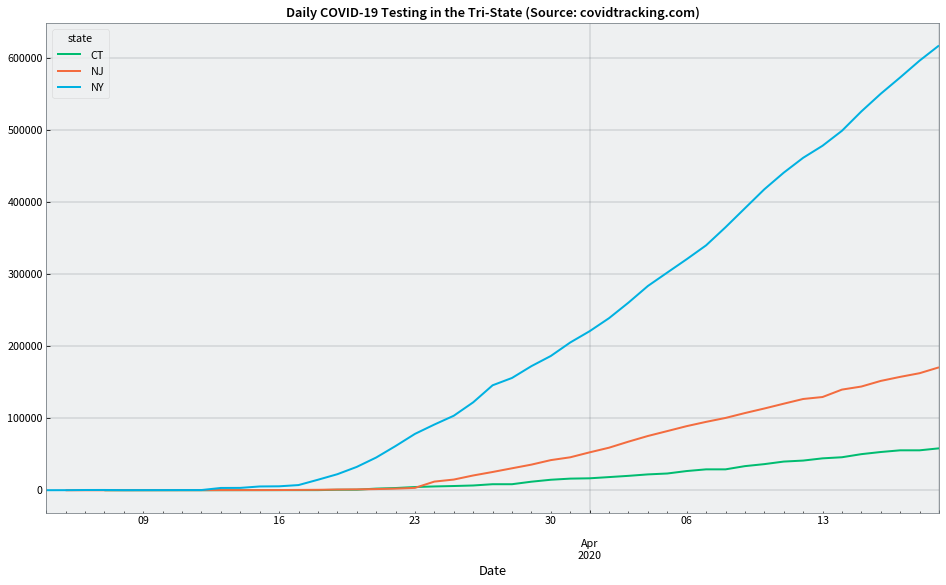

In [202]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY', 'CT', 'NJ'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Daily COVID-19 Testing in the Tri-State (Source: covidtracking.com)")

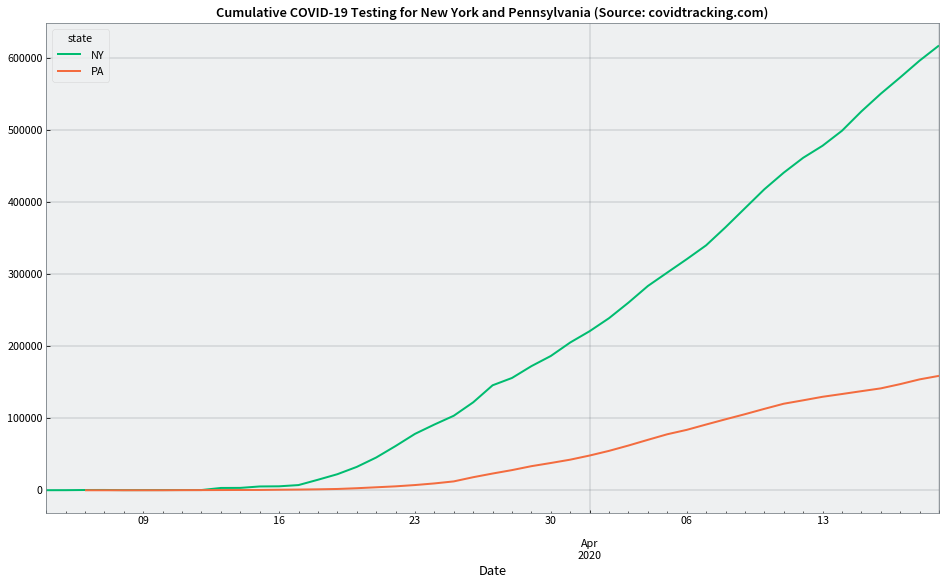

In [203]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY', 'PA'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for New York and Pennsylvania (Source: covidtracking.com)")

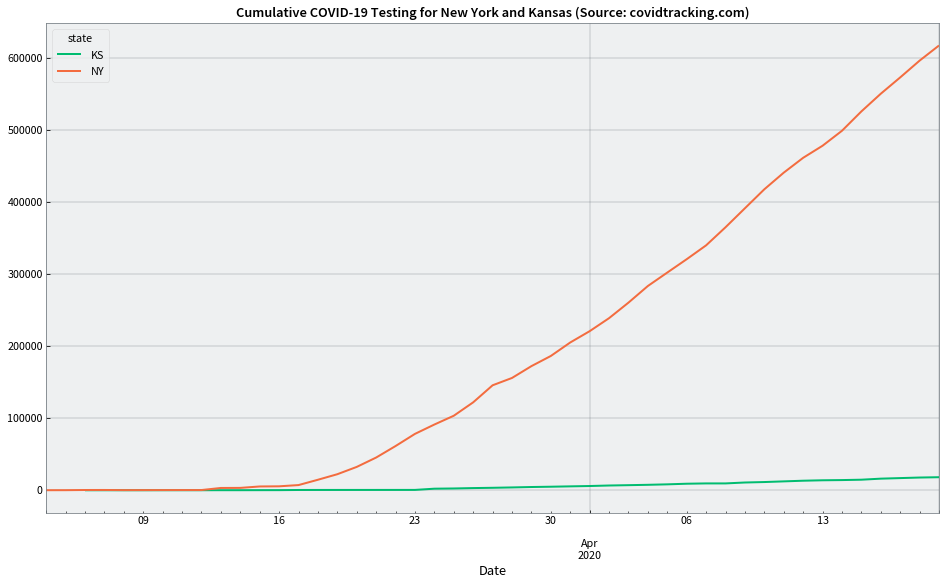

In [204]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY', 'KS'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for New York and Kansas (Source: covidtracking.com)")

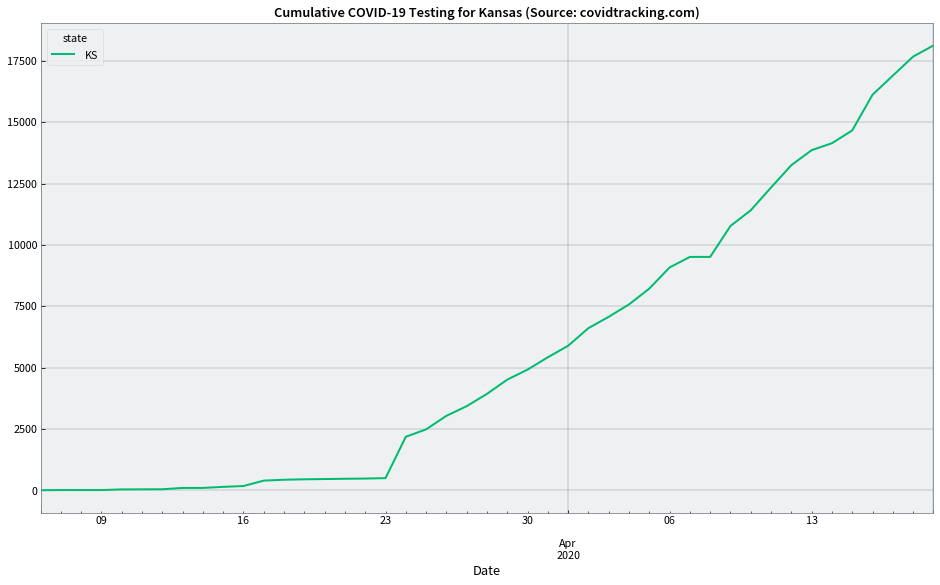

In [205]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['KS'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for Kansas (Source: covidtracking.com)")

In [206]:
tests_df.dtypes

date                                      int64
state                                    object
positive                                float64
negative                                float64
pending                                 float64
hospitalizedCurrently                   float64
hospitalizedCumulative                  float64
inIcuCurrently                          float64
inIcuCumulative                         float64
onVentilatorCurrently                   float64
onVentilatorCumulative                  float64
recovered                               float64
hash                                     object
dateChecked                 datetime64[ns, UTC]
death                                   float64
hospitalized                            float64
total                                   float64
totalTestResults                        float64
posNeg                                  float64
fips                                     object
deathIncrease                           

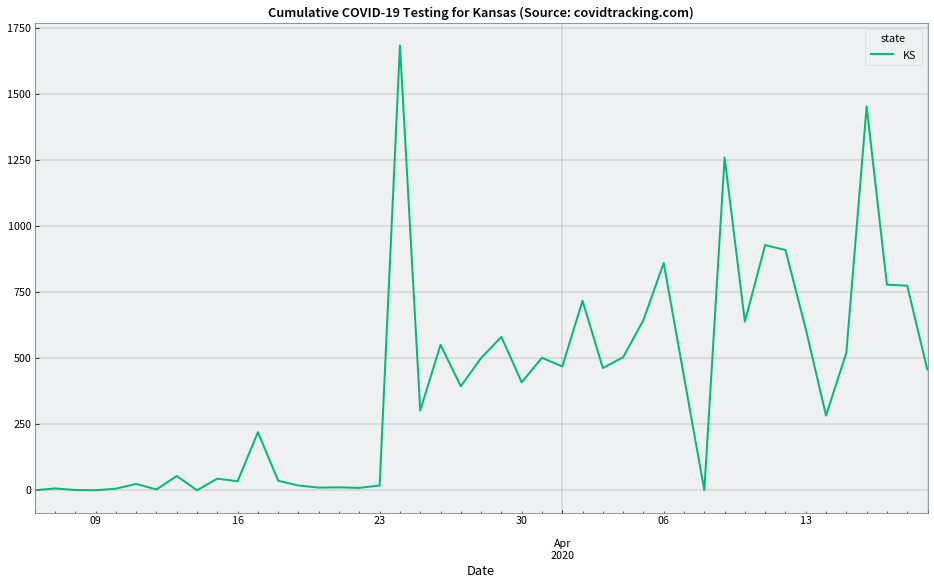

In [207]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['KS'])].groupby(['Date', 'state'])['totalTestResultsIncrease'].sum().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for Kansas (Source: covidtracking.com)")

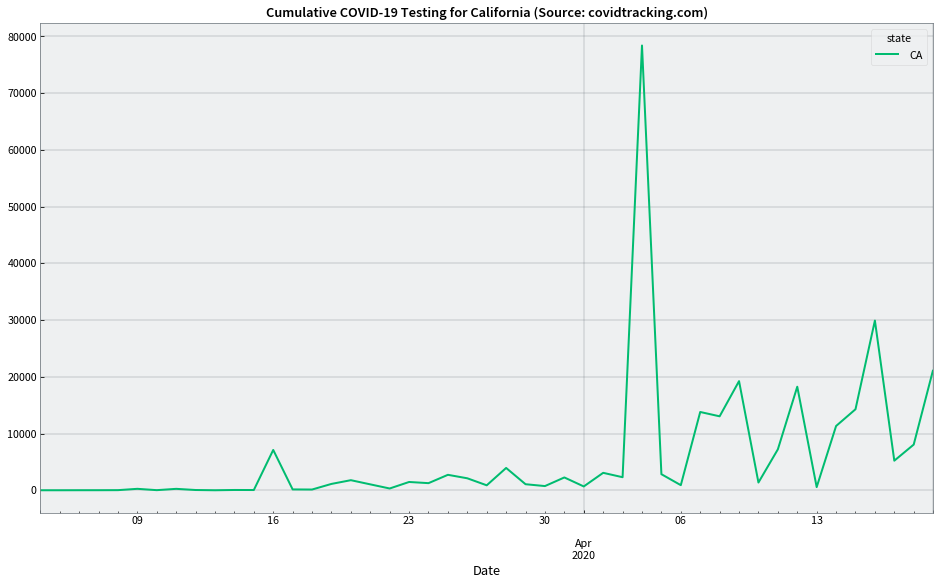

In [208]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['CA'])].groupby(['Date', 'state'])['totalTestResultsIncrease'].sum().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for California (Source: covidtracking.com)")

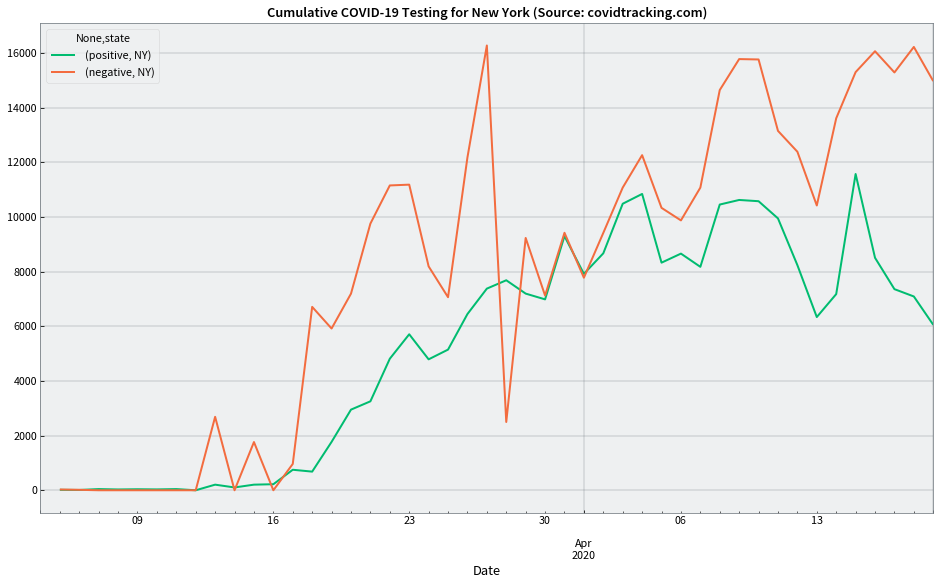

In [209]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY'])].groupby(['Date', 'state'])[['positive', 'negative']].max().diff().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for New York (Source: covidtracking.com)")

In [210]:
tests_df.dtypes

date                                      int64
state                                    object
positive                                float64
negative                                float64
pending                                 float64
hospitalizedCurrently                   float64
hospitalizedCumulative                  float64
inIcuCurrently                          float64
inIcuCumulative                         float64
onVentilatorCurrently                   float64
onVentilatorCumulative                  float64
recovered                               float64
hash                                     object
dateChecked                 datetime64[ns, UTC]
death                                   float64
hospitalized                            float64
total                                   float64
totalTestResults                        float64
posNeg                                  float64
fips                                     object
deathIncrease                           

In [211]:
((tests_df[tests_df['state'] == 'NY'].groupby('Date')['hospitalized'].max() / tests_df[tests_df['state'] == 'NY'].groupby('Date')['total'].max()) * 100)

Date
2020-03-04         NaN
2020-03-05         NaN
2020-03-06         NaN
2020-03-07         NaN
2020-03-08         NaN
2020-03-09         NaN
2020-03-10         NaN
2020-03-11         NaN
2020-03-12         NaN
2020-03-13         NaN
2020-03-14         NaN
2020-03-15         NaN
2020-03-16         NaN
2020-03-17         NaN
2020-03-18         NaN
2020-03-19         NaN
2020-03-20         NaN
2020-03-21    3.527962
2020-03-22    3.214931
2020-03-23    3.365735
2020-03-24    3.543333
2020-03-25    3.677075
2020-03-26    5.605058
2020-03-27    5.849622
2020-03-28    6.447600
2020-03-29    7.005686
2020-03-30    7.358367
2020-03-31    7.751016
2020-04-01    8.315828
2020-04-02    8.711318
2020-04-03    9.095655
2020-04-04    9.302203
2020-04-05    9.293370
2020-04-06    9.414577
2020-04-07    9.434567
2020-04-08    9.429472
2020-04-09    9.341360
2020-04-10    9.289159
2020-04-11    9.224681
2020-04-12    9.227450
2020-04-13    8.928896
2020-04-14    9.256065
2020-04-15    8.783260
2020-0

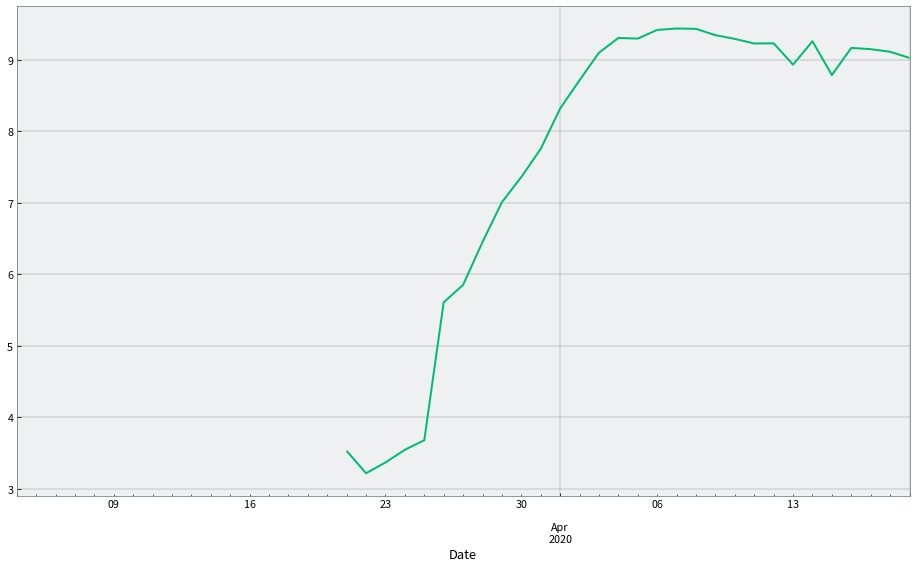

In [212]:
((tests_df[tests_df['state'] == 'NY'].groupby('Date')['hospitalized'].max() / tests_df[tests_df['state'] == 'NY'].groupby('Date')['total'].max()) * 100).plot(kind='line')

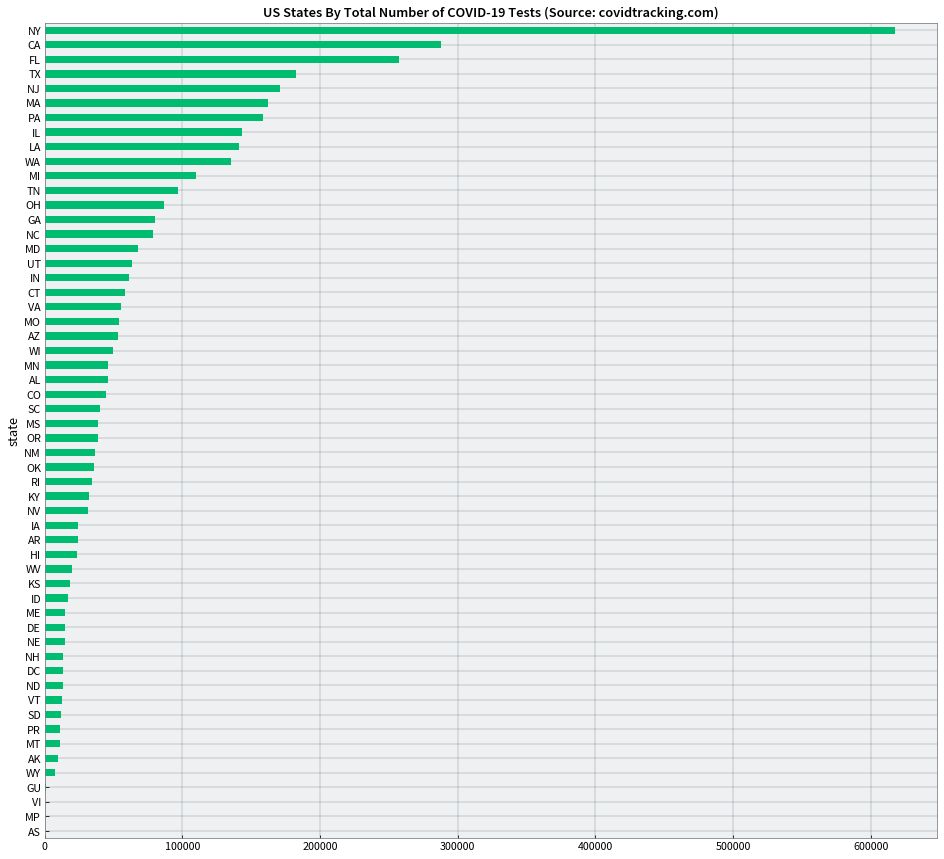

In [213]:
figsize(16,15)
tests_df.groupby('state')['total'].max().sort_values().plot(kind='barh',
                                                            title="US States By Total Number of COVID-19 Tests (Source: covidtracking.com)")

In [214]:
tests_df[tests_df['Date'] >= '2020-03-23'].groupby('state')['totalTestResultsIncrease'].mean().sort_values()

state
AS        0.107143
MP        2.000000
VI       21.250000
GU       33.071429
WY      243.535714
AK      318.821429
PR      331.678571
MT      347.178571
SD      403.607143
VT      413.142857
NH      434.678571
ND      440.785714
ME      449.642857
DC      451.571429
NE      506.107143
DE      525.071429
ID      559.000000
KS      630.321429
WV      701.214286
HI      827.107143
IA      830.178571
AR      833.321429
NV     1034.285714
KY     1094.785714
NM     1137.607143
RI     1203.000000
OK     1243.892857
OR     1286.178571
MS     1348.000000
SC     1386.392857
CO     1430.571429
MN     1465.571429
WI     1537.642857
AL     1575.357143
VA     1835.571429
AZ     1877.000000
MO     1908.928571
CT     1968.321429
IN     2130.285714
UT     2138.071429
MD     2412.607143
NC     2583.357143
GA     2711.178571
OH     3089.214286
TN     3332.892857
MI     3601.821429
WA     3862.000000
IL     4821.357143
LA     4928.785714
PA     5478.964286
MA     5576.285714
NJ     6015.964286
TX    

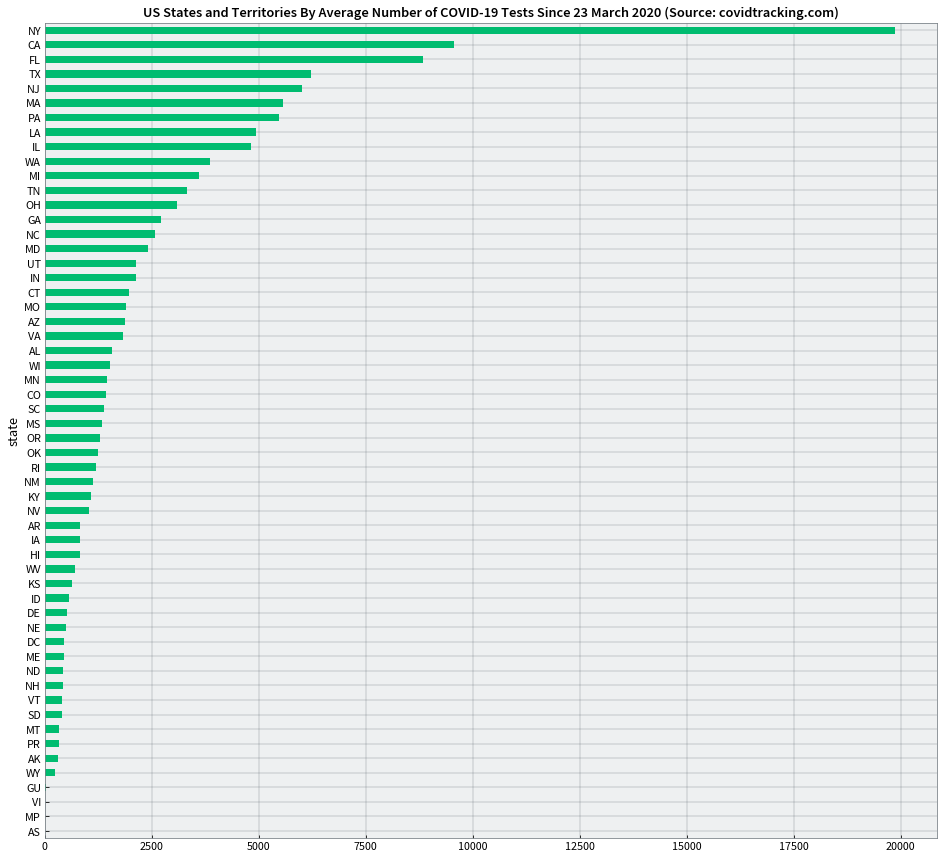

In [215]:
tests_df[tests_df['Date'] >= '2020-03-23'].groupby('state')['totalTestResultsIncrease'].mean().sort_values().plot(kind='barh',
                                                                                                                  title="US States and Territories By Average Number of COVID-19 Tests Since 23 March 2020 (Source: covidtracking.com)")

In [216]:
tests_df.groupby('state')['positive'].max().sort_values()

state
AS         0.0
MP        14.0
VI        53.0
GU       136.0
WY       309.0
AK       319.0
MT       433.0
HI       574.0
ND       585.0
VT       812.0
WV       863.0
ME       867.0
PR      1213.0
NE      1287.0
NH      1342.0
SD      1635.0
ID      1668.0
AR      1781.0
NM      1798.0
KS      1849.0
OR      1910.0
MN      2356.0
DE      2538.0
OK      2599.0
KY      2707.0
DC      2793.0
IA      2902.0
UT      3069.0
NV      3728.0
MS      4274.0
WI      4346.0
SC      4377.0
RI      4706.0
AL      4837.0
AZ      4929.0
MO      5667.0
NC      6493.0
TN      7070.0
VA      8537.0
CO      9433.0
IN     11210.0
OH     11292.0
WA     11802.0
MD     12830.0
CT     17550.0
GA     18301.0
TX     18923.0
LA     23928.0
FL     25996.0
CA     30333.0
IL     30357.0
MI     31424.0
PA     32284.0
MA     38077.0
NJ     85301.0
NY    242786.0
Name: positive, dtype: float64

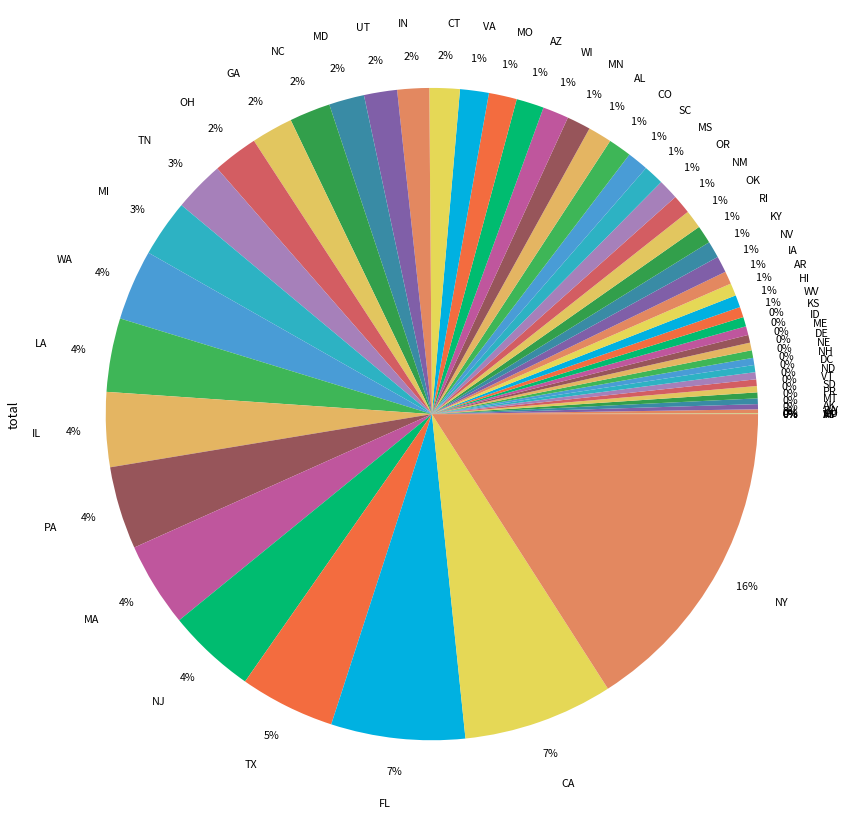

In [217]:
tests_df.groupby('state')['total'].max().sort_values().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, legend=False,)

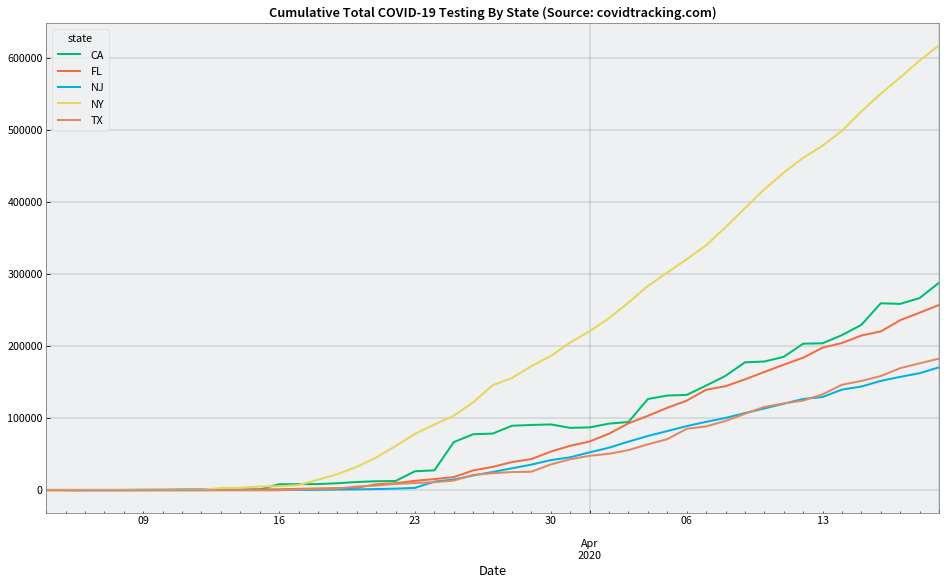

In [218]:
figsize(16, 9)
tests_df[tests_df['state'].isin(tests_df.groupby('state')['total'].max().sort_values()[-5:].index)].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                                                                     title="Cumulative Total COVID-19 Testing By State (Source: covidtracking.com)")

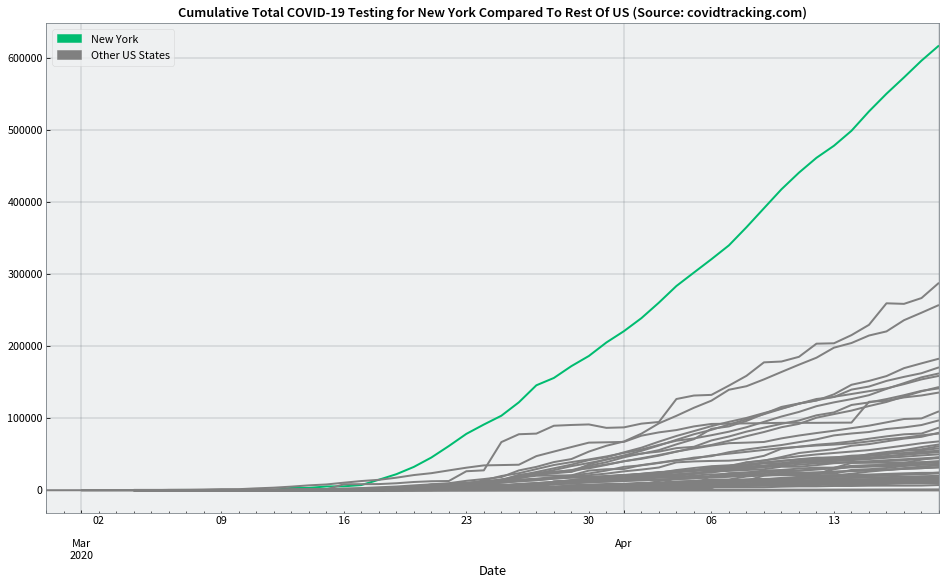

In [219]:


figsize(16, 9)
ax = tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                         title="Cumulative Total COVID-19 Testing for New York Compared To Rest Of US (Source: covidtracking.com)")

tests_df[-(tests_df['state'] == 'NY')].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                       color="gray",
                                                                                                       legend=False,
                                                                                                       ax=ax)

patch = mpatches.Patch(color="gray", label="Other US States")
ax.legend(handles=[mpatches.Patch(color="#00bc70", label="New York"),
                   mpatches.Patch(color="gray", label="Other US States")])

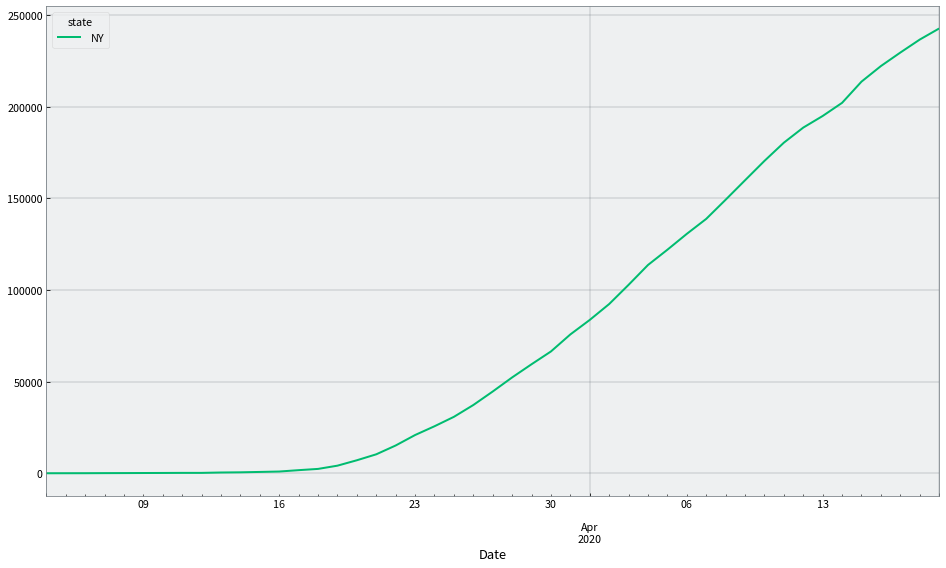

In [220]:
ax = tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['positive'].max().unstack('state').plot(kind='line', color="#00bc70", label="Positive COVID-19 Tests")

In [221]:
tests_df['New York?'] = tests_df['state'].str.contains('NY')

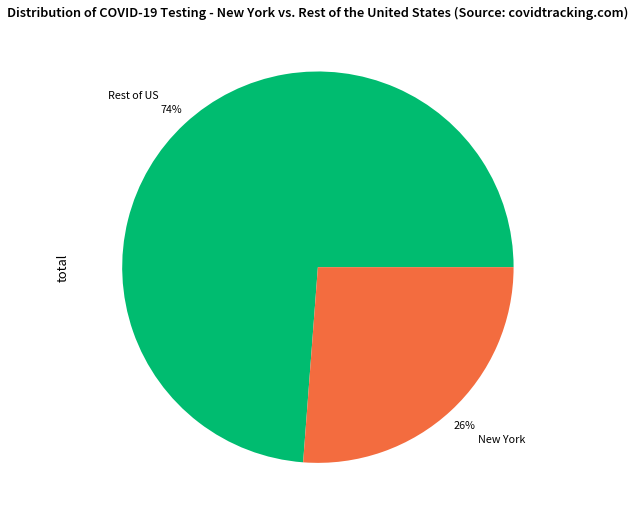

In [222]:
ax = tests_df[tests_df['Date'] == '2020-03-22'].groupby('New York?')['total'].sum().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, legend=False,
                                                       title="Distribution of COVID-19 Testing - New York vs. Rest of the United States (Source: covidtracking.com)",
                                                       labels=['Rest of US', 'New York'])

In [223]:
tests_df[tests_df['Date'] == '2020-03-22'].groupby('New York?')['total'].sum()

New York?
False    172938.0
True      61401.0
Name: total, dtype: float64

In [224]:
tests_df.groupby(['Date', 'New York?'])['total'].sum().unstack('New York?').diff()

New York?,False,True
Date,,
2020-02-28,NaN,NaN
2020-02-29,9.0,NaN
2020-03-01,22.0,NaN
2020-03-02,13.0,NaN
2020-03-03,47.0,NaN
2020-03-04,893.0,NaN
2020-03-05,328.0,44.0
2020-03-06,758.0,239.0
2020-03-07,508.0,43.0


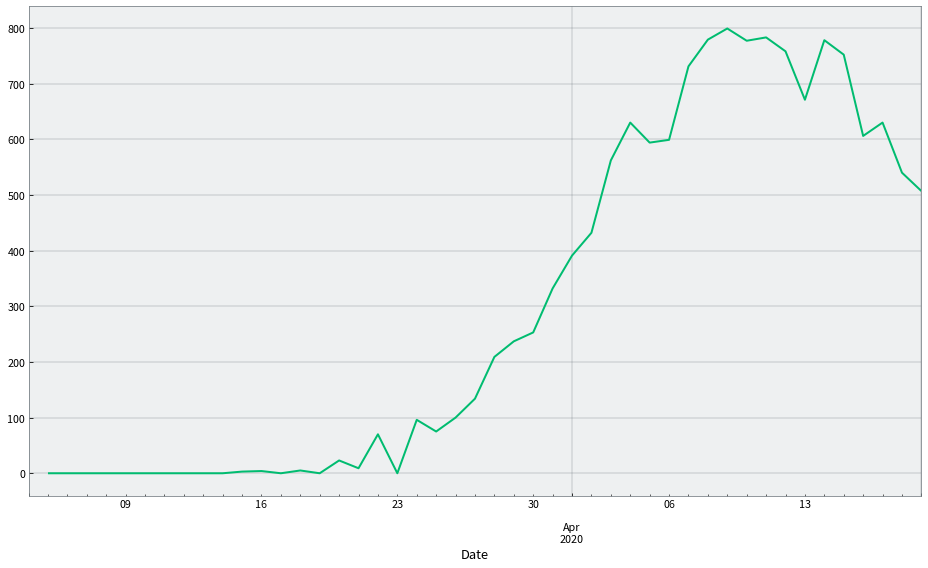

In [225]:
tests_df[tests_df['state'] == 'NY'].groupby('Date')['death'].sum().diff().plot(kind='line')

In [230]:
tests_df.groupby('State')['Tests per Capita'].max().sort_values()

State
Texas                   0.006199
Kansas                  0.006229
Virginia                0.006403
Kentucky                0.007162
Arizona                 0.007182
California              0.007214
Ohio                    0.007405
North Carolina          0.007423
Georgia                 0.007445
Nebraska                0.007465
Colorado                0.007631
Iowa                    0.007720
South Carolina          0.007770
Arkansas                0.007966
Minnesota               0.008019
Wisconsin               0.008530
Missouri                0.008738
Oklahoma                0.008993
Indiana                 0.009064
Oregon                  0.009076
Idaho                   0.009237
Alabama                 0.009313
New Hampshire           0.010020
Montana                 0.010028
Nevada                  0.010064
Michigan                0.010917
Maine                   0.011104
Maryland                0.011161
West Virginia           0.011266
Illinois                0.011321
Flor

# Kansas

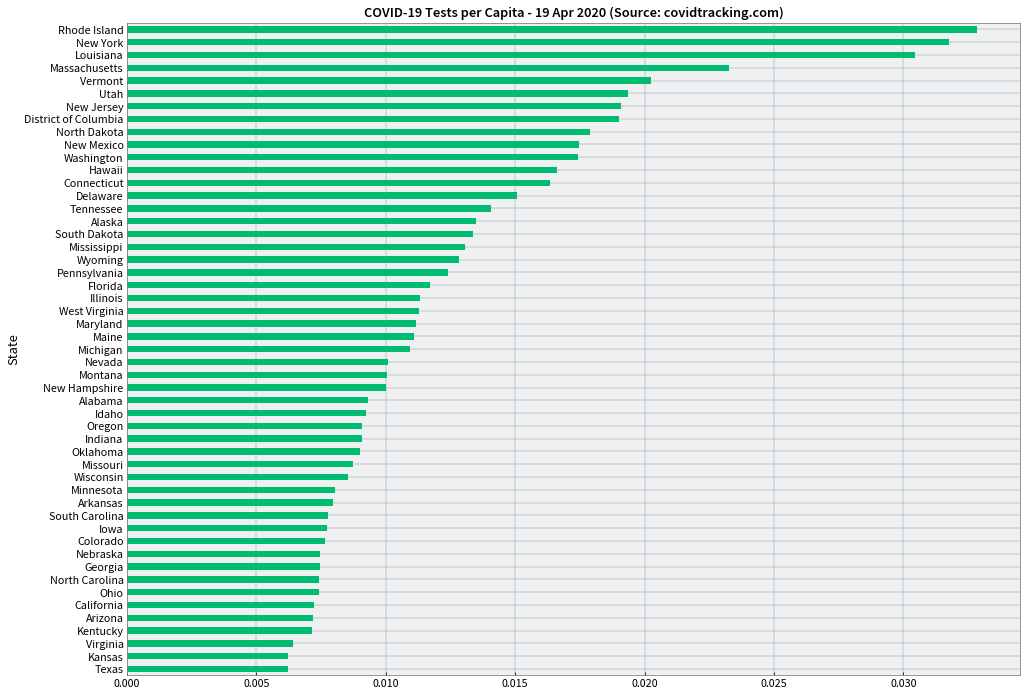

In [227]:
figsize(16, 12)
tests_df.groupby('State')['Tests per Capita'].max().sort_values()[:-4].plot(kind='barh',
                                                                            title="COVID-19 Tests per Capita - {0} (Source: covidtracking.com)".format(tests_df['Date'].max().strftime("%d %b %Y")))

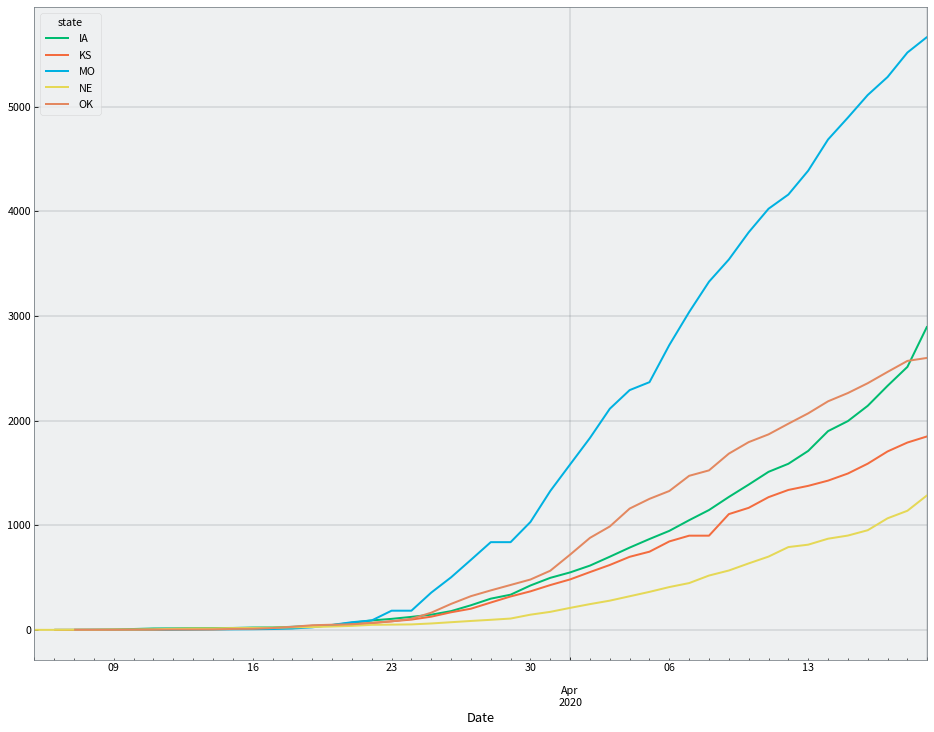

In [228]:
tests_df[tests_df['state'].isin(['KS', 'NE', 'OK', 'IA', 'MO'])].groupby(['Date', 'state'])['positive'].sum().unstack('state').plot(kind='line')

# Pennsylvania

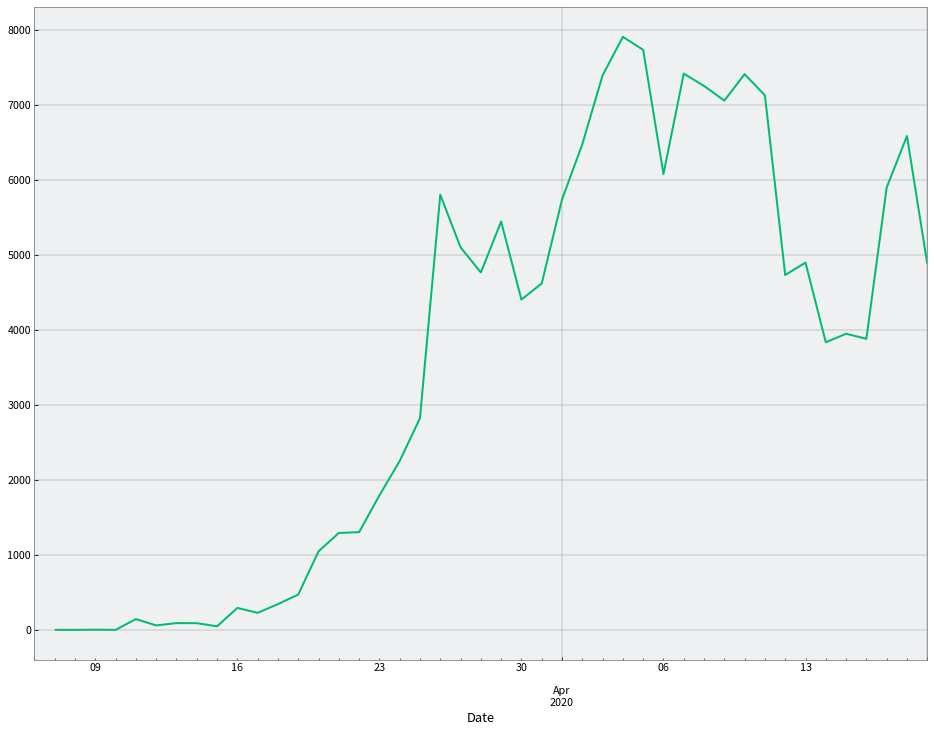

In [229]:
tests_df[tests_df['state'] == 'PA'].groupby('Date')['total'].max().diff().plot(kind='line')

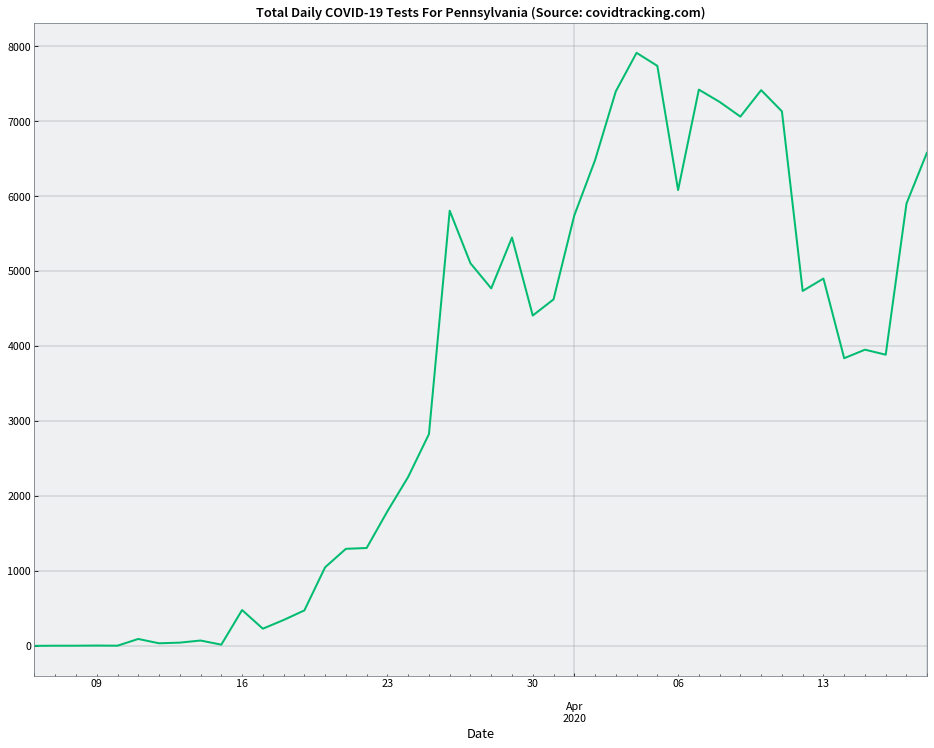

In [175]:
tests_df[tests_df['state'] == 'PA'].groupby('Date')['totalTestResultsIncrease'].sum().plot(kind='line',
                                                                                           title="Total Daily COVID-19 Tests For Pennsylvania (Source: covidtracking.com)") 